In [1]:
import sys
#sys.path.insert(0, '../third/xgboost.m/python-package/build/lib/')
sys.path.insert(0, '../third/xgboost/python-package/build/lib/')

In [2]:
%pylab inline
import pandas as pd
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [3]:
xgb.__version__

''

In [4]:
df=pd.read_csv('../input/train2016_withy.csv')

In [5]:
#df=df.loc[np.random.permutation(df.index)]

In [6]:
trainx=df.drop(['parcelid','logerror'],axis=1)
trainy=df['logerror']

In [7]:
trainx.shape

(90811, 95)

In [8]:
#split = 80000
#x_train, y_train, x_valid, y_valid = trainx[:split], trainy[:split], trainx[split:], trainy[split:]

print('Building DMatrix...')

d_train = xgb.DMatrix(trainx, label=trainy)
#d_valid = xgb.DMatrix(x_valid, label=y_valid)




Building DMatrix...


In [103]:
mae(fs.y),mae(trainy)

(0.06720220971297101, 0.06901750448734861)

In [104]:
d_train = xgb.DMatrix(fs.X, label=fs.y)

In [106]:
print('Training ...')

params = {}
params['eta'] = 0.02
params['objective'] = 'reg:smoothl1'
#params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 10
#params['subsample'] = 0.7
#params['colsample_bytree'] = 0.8
params['silent'] = 1
params['base_score'] = 0
params['min_child_weight']=50
params['tree_method']='hist'

watchlist = [(d_train, 'train')]
clf = xgb.train(params, d_train, 60, watchlist, early_stopping_rounds=50, verbose_eval=10)


Training ...
[0]	train-mae:0.066983
Will train until train-mae hasn't improved in 50 rounds.
[10]	train-mae:0.065767
[20]	train-mae:0.064748
[30]	train-mae:0.063918
[40]	train-mae:0.063123
[50]	train-mae:0.062606
[59]	train-mae:0.061992


In [107]:
0.991688/15.

0.06611253333333333

In [108]:
clf.best_ntree_limit

60

In [109]:
print clf.get_dump(dump_format='text')[7]

0:[yardbuildingsqft26<15] yes=1,no=2,missing=2
	1:leaf=-0.00542197
	2:[finishedsquarefeet12<56] yes=3,no=4,missing=3
		3:[propertyzoningdesc_I<0] yes=5,no=6,missing=5
			5:[airconditioningtypeid<12] yes=9,no=10,missing=9
				9:[longitude<-1.17582e+08] yes=17,no=18,missing=17
					17:[propertycountylandusecode_01DC<0] yes=31,no=32,missing=31
						31:[regionidneighborhood<764108] yes=51,no=52,missing=51
							51:[regionidneighborhood<403194] yes=77,no=78,missing=77
								77:[pooltypeid7<0] yes=105,no=106,missing=105
									105:[landtaxvaluedollarcnt<299000] yes=133,no=134,missing=133
										133:leaf=5.50443e-05
										134:leaf=-0.000413406
									106:[daysInYear1<216] yes=135,no=136,missing=135
										135:leaf=0.000725743
										136:leaf=-0.000567416
								78:[lotsizesquarefeet<155] yes=107,no=108,missing=107
									107:[lotsizesquarefeet<138] yes=137,no=138,missing=137
										137:leaf=0.00109871
										138:leaf=0.00818337
									108:[regionidzip<96123] ye

In [110]:
import json
trees=[json.loads(u) for u in clf.get_dump(dump_format='json')[:clf.best_ntree_limit]]
len(trees)

60

In [111]:
def parse_tree_(node):
    if 'leaf' in node:
        return [[]]
    nodeid=node['nodeid']
    split=node['split']
    split_cond=node['split_condition']
    yes=node['yes']
    no=node['no']
    missing=node['missing']
    children1=parse_tree_([u for u in node["children"] if u['nodeid']==yes][0])
    children2=parse_tree_([u for u in node["children"] if u['nodeid']==no][0])
    cond1=[('yes',split,split_cond)]
    cond2=[('no',split,split_cond)]
    if missing==yes:
        cond1.append(('missing',split))
    elif missing==no:
        cond2.append(('missing',split))
    else:
        raise 2
    ret1=[[cond1]+u for u in children1]
    ret2=[[cond2]+u for u in children2]
    return ret1+ret2
    
def parse_tree(node):
    ret=parse_tree_(node)
    ret=[tuple(tuple(v) for v in u) for u in ret]
    return ret
        

In [112]:
parse_tree(trees[0])

[((('yes', u'yearbuilt', 2010), ('missing', u'yearbuilt')),
  (('yes', u'regionidcity', 15554),),
  (('yes', u'landtaxvaluedollarcnt', 465600),
   ('missing', u'landtaxvaluedollarcnt')),
  (('yes', u'regionidzip', 97319), ('missing', u'regionidzip')),
  (('yes', u'propertyzoningdesc_M', 0), ('missing', u'propertyzoningdesc_M')),
  (('yes', u'lotsizesquarefeet', 78), ('missing', u'lotsizesquarefeet')),
  (('yes', u'regionidneighborhood', 41131),),
  (('yes', u'yearbuilt', 1926),)),
 ((('yes', u'yearbuilt', 2010), ('missing', u'yearbuilt')),
  (('yes', u'regionidcity', 15554),),
  (('yes', u'landtaxvaluedollarcnt', 465600),
   ('missing', u'landtaxvaluedollarcnt')),
  (('yes', u'regionidzip', 97319), ('missing', u'regionidzip')),
  (('yes', u'propertyzoningdesc_M', 0), ('missing', u'propertyzoningdesc_M')),
  (('yes', u'lotsizesquarefeet', 78), ('missing', u'lotsizesquarefeet')),
  (('yes', u'regionidneighborhood', 41131),),
  (('no', u'yearbuilt', 1926), ('missing', u'yearbuilt')),
  ((

In [113]:
def enumerate_all_conds(tree):
    ret=[]
    cond_list=(parse_tree(tree))
    for cond in cond_list:
        for i in range(len(cond)):
            ret.append(cond[:i+1])
    return ret

In [114]:
cond_list=(enumerate_all_conds(trees[8]))
len(cond_list)

1129

In [115]:
def value_cond_tuple (df,cond):
    #print cond
    col=cond[1]
    if cond[0]=='missing':
        return np.isnan(df[col])
    else:
        split_val=cond[2]
        if cond[0]=='yes':
            return df[col]<split_val
        elif cond[0]=='no':
            return df[col]>=split_val
        else:
            raise "never be here"
def value_cond_single(df,conds):
    return reduce(lambda u,v: u | v, [value_cond_tuple(df,cond) for cond in conds])
def value_cond(df,conds):
    return reduce(lambda u,v: u & v, [value_cond_single(df,cond) for cond in conds])
def cond_trees(trees):
    cond_lists=reduce(lambda u,v: u+v, [enumerate_all_conds(tree) for tree in trees])
    cond_lists=list(set(cond_lists))
    print len(cond_lists)
    return cond_lists 
def value_trees(df,trees):
    cond_lists=cond_trees(trees)
    return cond_lists, [value_cond(df, conds) for conds in cond_lists]

In [116]:
len(trees)

60

In [117]:
cond_lists=cond_trees(trees)

12640


In [72]:
df.values.nbytes/1024.**2

67.20479583740234

In [73]:
from sklearn.utils import resample
import scipy.stats 

In [74]:
def mae(y):
    m=np.median(y)
    return np.mean(np.abs(y-m))
def evaluate_cond(cond,X,y,n=500):
    v=value_cond(X,cond)
    newy=y[v]
    lst=[]
    for _ in range(n):
        ry=resample(newy)
        lst.append(np.median(ry))
    m,s=np.mean(lst),np.std(lst)
    p_values = scipy.stats.norm.sf(abs(m/s))*2
    yy=y-v*m
    gain = mae(y)-mae(yy)
    return float(np.sum(v)), float(gain), float(m),float(s),float(np.round(p_values,6))
        

In [75]:
c=evaluate_cond(cond_lists[0],trainx,trainy)
c

(65.0,
 3.5196177546048535e-07,
 -0.0025961999999999995,
 0.005037360971778774,
 0.606281)

In [26]:
import findspark
findspark.init()

In [27]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
conf = SparkConf()
conf.set('spark.executor.cores',4)
conf.set('spark.executor.instances',1) 
conf.set('spark.speculation','true') 
conf.set('spark.driver.memory','40G') 
conf.set('spark.executor.memory','20G') 

#conf.set('spark.cores.max',15)     
conf.setAppName("spark")
conf.setMaster("spark://192.168.0.11:7077")
#conf.setMaster("local[6]")

/home/spark/software/spark-2.0.1-bin-hadoop2.7/python/pyspark/sql/context.py:487: DeprecationWarning: HiveContext is deprecated in Spark 2.0.0. Please use SparkSession.builder.enableHiveSupport().getOrCreate() instead.
  DeprecationWarning)


In [28]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc=spark.sparkContext

In [29]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

In [49]:
class FeatSel(object):
    def __init__(self,rawX,rawy,conds_list):
        self.X=rawX.copy()
        self.b=np.median(rawy)
        self.y=rawy-self.b
        self.conds_list=conds_list
        self.feats=[]
    def updatey(self,feat,stat):
        v= value_cond(self.X,feat)
        vy=self.y[v]
        oldy=self.y
        self.y=self.y-v*stat['m']
        #print np.median(vy) ,np.median(self.y[v])        
        return mae(oldy)-mae(self.y)
    def step(self):
        Xy_bc=sc.broadcast((self.X,self.y))
        condsDF=sc.parallelize(self.conds_list,1000)
        print "#feats", condsDF.count()      
        eval_results=condsDF.map(lambda u: evaluate_cond(u,X=Xy_bc.value[0],y=Xy_bc.value[1])).collect()
        df=pd.DataFrame(eval_results,columns=['n','gain','m','sd','p'])
        df[df['p']<0.02]
        if df.shape[0]==0:
            print "no feat selected"
            return False
        else:
            df=df.sort_values("gain",ascending=False)
            selidx=df.index[0]
            selfeat=self.conds_list[selidx]
            print "sel feat", selidx, str(selfeat)
            stat=df.iloc[0].to_dict()
            print "stat: ", str(stat)
            gain=self.updatey(selfeat,stat)
            Xy_bc.destroy()
            print "verifed gain:",gain
            print "MAE:", mae(self.y)
            if gain<1.1e-5:
                return False
            else:
                self.feats.append((selidx,selfeat,stat))            
                return True

In [118]:
mae(trainy),np.median(trainy),np.mean(np.abs(trainy))

(0.06901750448734861, 0.0050000000000000001, 0.06931706070851183)

In [102]:
import cPickle as pickle
if 1: pickle.dump(fs,open('fs_3.pkl','wb'))

In [53]:
fs=FeatSel(trainx,trainy,conds_list=cond_lists[:])

In [119]:
fs.conds_list=cond_lists

In [ ]:
%time while(fs.step()): pass

#feats 12640
sel feat 4566 ((('yes', u'yearbuilt', 2010), ('missing', u'yearbuilt')), (('no', u'regionidcity', 15554), ('missing', u'regionidcity')), (('yes', u'propertycountylandusecode_34', 0), ('missing', u'propertycountylandusecode_34')), (('yes', u'finishedsquarefeet50', 46), ('missing', u'finishedsquarefeet50')), (('yes', u'daysInYear1', 76), ('missing', u'daysInYear1')), (('yes', u'landtaxvaluedollarcnt', 158434),), (('yes', u'propertycountylandusecode_1111', 0), ('missing', u'propertycountylandusecode_1111')), (('no', u'regionidzip', 96151),), (('yes', u'yearbuilt', 1964),), (('yes', u'regionidneighborhood', 275067), ('missing', u'regionidneighborhood')))
stat:  {'p': 0.0, 'sd': 0.0016060416036277577, 'm': 0.011960549459398758, 'gain': 1.6247326982701815e-05, 'n': 1133.0}
verifed gain: 1.62473269827e-05
MAE: 0.067185962386
#feats 12640
sel feat 1631 ((('yes', u'propertyzoningdesc_I', 0), ('missing', u'propertyzoningdesc_I')), (('no', u'structuretaxvaluedollarcnt', 199602), ('mi

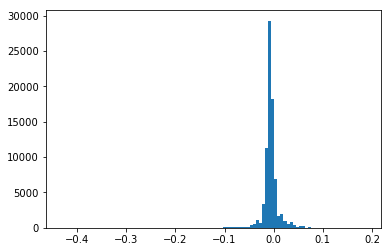

In [50]:
plt.hist(fs.y-y_train,bins=100);

In [80]:
np.mean(fs.y),np.median(fs.y),np.mean(trainy)

(0.0054871434510978465, 0.00032101243777940894, 0.01081647157282662)

In [81]:
mae(fs.y)

0.06751850698070253

In [104]:
condsDF=sc.parallelize(cond_lists[:30],1000)

In [153]:
eval_results=condsDF.map(lambda u: evaluate_cond(u,X=Xy_bc.value[0],y=Xy_bc.value[1])).collect()

In [154]:
len(x_train)

80000

In [155]:
df=pd.DataFrame(eval_results,columns=['n','gain','m','sd','p'])
df=df.sort_values("gain",ascending=False)

In [156]:
df[df['p']<0.05]

n          gain         m        sd         p
5   1268.0  1.769818e-05  0.014583  0.001881  0.000000
21  1719.0  1.048334e-05  0.005703  0.001355  0.000026
20    82.0  7.805122e-06  0.042289  0.008920  0.000002
27   703.0  5.189973e-06  0.006083  0.002515  0.015573
4   1212.0  3.832921e-06  0.003765  0.001548  0.014991
22   150.0  3.128936e-06  0.020587  0.003332  0.000000
12   136.0  2.348593e-06  0.015604  0.006976  0.025300
1    146.0  1.909942e-06  0.016727  0.005591  0.002776
16    53.0  1.296412e-06  0.031100  0.007196  0.000015
19   314.0  1.018784e-06  0.005722  0.002257  0.011228
24    72.0 -5.924227e-07 -0.011321  0.005133  0.027417
9    372.0 -9.794574e-06 -0.017206  0.005743  0.002737
26  3148.0 -1.012016e-05 -0.003257  0.000835  0.000095
29  5619.0 -1.949563e-05 -0.003744  0.000794  0.000002
18  2215.0 -4.721819e-05 -0.011069  0.002089  0.000000

In [158]:
df.gain.sum()*1000

-0.023877345226686053